In [133]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [134]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [135]:
df = pd.read_excel(
    r"C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\ipynb\clinical_biomarker_NF.xlsx"
)

print(df.shape)
df.head()


(1000, 34)


,age,gender,height,weight,occupation,physical_activity_level,living_environment,do_you_currently_experience_knee_pain,pain_score,stiffness,...,does_the_patient_have_any_other_health_conditions_or_risk_factors_that_may_contribute_to_knee_osteoarthritis,what_are_the_suggested_or_ongoing_treatments_for_the_patients_current_condition,koa,does_the_patient_has_obesity,does_the_patient_has_diabetes,does_the_patient_has_hypertension,does_the_patient_has_vitamin_d_deficiency,does_the_patient_has_rheumatoid_arthritis,bmi,koa_grade
0,70.0,Female,1.55,60.0,No,Moderate,Urban,Yes,3.0,Frequently,...,"Obesity or overweight, Family history of osteo...","0 = Lifestyle modification, 1 = Physiotherapy,...",Yes,Yes,No,No,No,No,24.973985,1
1,48.0,Female,1.57,70.0,No,Moderate,Rural,Yes,4.0,Frequently,...,Family history of osteoarthritis,"0 = Lifestyle modification, 1 = Physiotherapy,...",Yes,No,No,No,No,No,28.398718,2
2,54.0,Female,1.58,76.0,No,Moderate,Urban,Yes,3.0,Never,...,"Vitamin D deficiency, Sedentary or low-activit...","0 = Lifestyle modification, 1 = Physiotherapy,...",Yes,No,No,No,Yes,No,30.443839,3
3,52.0,Female,1.55,60.0,No,Low,Urban,Yes,2.0,Occasionally,...,None of the above,"2 = Medication,",Yes,No,No,No,No,No,24.973985,1
4,74.0,Female,1.55,63.0,No,Moderate,Urban,Yes,2.0,Occasionally,...,Vitamin D deficiency,2 = Medication,Yes,No,No,No,Yes,No,26.222685,1


In [136]:
TARGET = "koa_grade"

X = df.drop(columns=[TARGET, "koa_severity"])
y = df[TARGET]

print(X.shape, y.shape)


(1000, 32) (1000,)


In [137]:
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['age', 'height', 'weight', 'pain_score', 'fbs', 'wbc', 'platelets', 'cs', 'cholesterol', 'crp', 'esr', 'rf', 'fbc', 'bmi']
Categorical columns: ['gender', 'occupation', 'physical_activity_level', 'living_environment', 'do_you_currently_experience_knee_pain', 'stiffness', 'have_you_had_any_previous_knee_injuries_(acl_tear,_meniscus_tear,_fracture,_etc.)', 'do_you_experience_swelling_in_your_knees', 'do_you_find_difficulty_in_performing_these_activities_(check_all_that_apply)', 'do_you_have_a_family_history_of_osteoarthritis', 'does_the_patient_have_any_other_health_conditions_or_risk_factors_that_may_contribute_to_knee_osteoarthritis', 'what_are_the_suggested_or_ongoing_treatments_for_the_patients_current_condition', 'koa', 'does_the_patient_has_obesity', 'does_the_patient_has_diabetes', 'does_the_patient_has_hypertension', 'does_the_patient_has_vitamin_d_deficiency', 'does_the_patient_has_rheumatoid_arthritis']


In [138]:
# Ordinal Encoding of stiffness
ordinal_maps = {
    "stiffness": ["never", "occasionally", "frequently", "always"]
}

for col, order in ordinal_maps.items():
    if col in X.columns:
        X[col] = pd.Categorical(X[col], categories=order, ordered=True).codes


In [139]:
# One-Hot Encoding for Nominal Categorical Variables
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [140]:
# Feature Scaling (Standardization)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

In [141]:
import json, os, joblib

# ✅ SAVE feature names (this becomes your 104 columns)
feature_names = list(X.columns)
print("Feature count:", len(feature_names))

os.makedirs("models", exist_ok=True)

with open("models/xgb_feature_names.json", "w") as f:
    json.dump(feature_names, f)

joblib.dump(scaler, "models/xgb_scaler.pkl")

print("Saved: models/xgb_feature_names.json")
print("Saved: models/xgb_scaler.pkl")


Feature count: 104
Saved: models/xgb_feature_names.json
Saved: models/xgb_scaler.pkl


In [142]:
# Train–Test-Validation Split 

from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.20,
    stratify=y_trainval,
    random_state=42
)


In [143]:
# Convert Pandas DataFrames to NumPy Arrays

X_train_np = X_train.to_numpy()
X_val_np   = X_val.to_numpy()
X_test_np  = X_test.to_numpy()

y_train_np = y_train.to_numpy()
y_val_np   = y_val.to_numpy()
y_test_np  = y_test.to_numpy()


In [144]:
# Initialize the XGBoost Classifier

from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=3,              # reduce depth
    learning_rate=0.05,
    subsample=0.8,             # stronger randomness
    colsample_bytree=0.8,
    min_child_weight=7,        # prevent small leaf splits
    gamma=0.2,                 # penalize complex splits
    reg_alpha=5.0,             # L1 regularization
    reg_lambda=3.0,            # L2 regularization
    objective="multi:softmax",
    num_class=5,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)


xgb.fit(X_train_np, y_train_np)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1, num_class=5, ...)

In [145]:
xgb_train_pred = xgb.predict(X_train_np)
xgb_train_acc = accuracy_score(y_train_np, xgb_train_pred)

print("XGBoost - Training Accuracy: {:.2f}%".format(xgb_train_acc * 100))


XGBoost - Training Accuracy: 95.00%


In [146]:
import numpy as np

def within_one(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) <= 1)

from sklearn.metrics import accuracy_score, classification_report


y_pred_xgb = xgb.predict(X_test_np)

print("XGBoost - Test Accuracy:",
      accuracy_score(y_test_np, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test_np, y_pred_xgb, zero_division=0))



XGBoost - Test Accuracy: 0.965

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      0.93      0.95        30
           2       0.91      1.00      0.95        52
           3       0.98      0.95      0.97        65
           4       1.00      0.88      0.94        17

    accuracy                           0.96       200
   macro avg       0.97      0.95      0.96       200
weighted avg       0.97      0.96      0.96       200



In [147]:
xgb_val_pred = xgb.predict(X_val_np)
xgb_val_acc = accuracy_score(y_val_np, xgb_val_pred)

print("XGBoost - Validation Accuracy: {:.2f}%".format(xgb_val_acc * 100))


XGBoost - Validation Accuracy: 94.38%


In [148]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    xgb,
    X_test_np,
    y_test_np,
    n_repeats=10,
    random_state=42,
    scoring="accuracy"
)

perm_df = pd.DataFrame({
    "feature": feature_names,
    "perm_importance": perm.importances_mean,
    "perm_std": perm.importances_std
}).sort_values("perm_importance", ascending=False)

# Save full list
perm_df.to_csv("xgb_all_features_permutation.csv", index=False)

print("Total features with permutation importance:", perm_df.shape[0])
print(perm_df.head(20))


Total features with permutation importance: 104
                                              feature  perm_importance  \
3                                          pain_score           0.5195   
7                                                  cs           0.0085   
6                                           platelets           0.0080   
11                                                 rf           0.0075   
9                                                 crp           0.0035   
4                                                 fbs           0.0035   
10                                                esr           0.0035   
2                                              weight           0.0030   
5                                                 wbc           0.0025   
17                   physical_activity_level_Moderate           0.0020   
15                                     occupation_Yes           0.0010   
79  does_the_patient_have_any_other_health_conditi...           

Number of features (50% threshold): 12
Number of features (25% threshold): 12


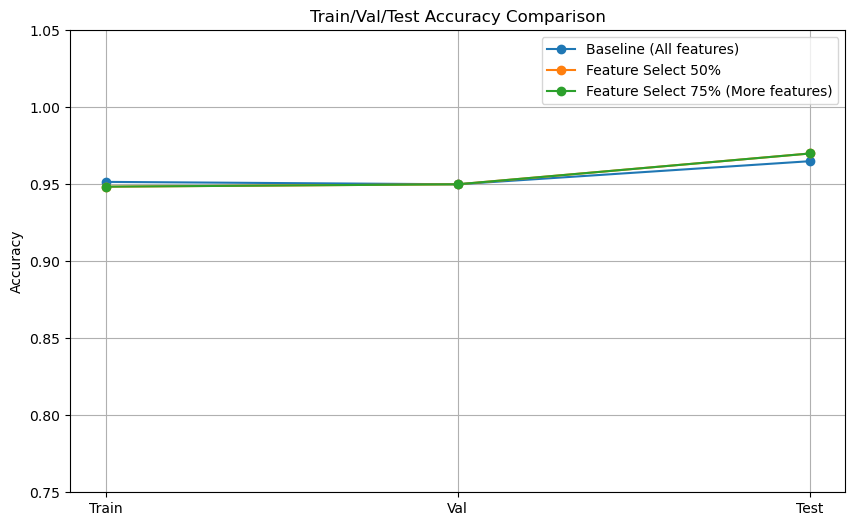


Classification Report (TEST) for Feature Select 75%:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.97      1.00      0.98        30
           2       0.93      1.00      0.96        52
           3       0.98      0.94      0.96        65
           4       1.00      0.88      0.94        17

    accuracy                           0.97       200
   macro avg       0.98      0.96      0.97       200
weighted avg       0.97      0.97      0.97       200



In [149]:
import json, joblib, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.inspection import permutation_importance

from xgboost import XGBClassifier

# 1) LOAD DATA
df = pd.read_excel(
    r"C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\ipynb\clinical_biomarker_NF.xlsx"
)

TARGET = "koa_grade"
X = df.drop(columns=[TARGET, "koa_severity"])
y = df[TARGET]

# 2) ENCODING + SCALING
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

if "stiffness" in X.columns:
    order = ["Never", "Occasionally", "Frequently", "Always"]
    X["stiffness"] = pd.Categorical(X["stiffness"], categories=order, ordered=True).codes

X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])

feature_names = X.columns.tolist()

# 3) SPLIT
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20,
    stratify=y_trainval, random_state=42
)

# 4) BASELINE MODEL (ALL FEATURES)
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=7,
    gamma=0.2,
    reg_alpha=5.0,
    reg_lambda=3.0,
    objective="multi:softmax",
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)

baseline_train_acc = accuracy_score(y_train, xgb.predict(X_train))
baseline_val_acc = accuracy_score(y_val, xgb.predict(X_val))
baseline_test_acc = accuracy_score(y_test, xgb.predict(X_test))

# 5) PERMUTATION IMPORTANCE
perm = permutation_importance(
    xgb,
    X_val,
    y_val,
    n_repeats=10,
    random_state=42,
    scoring="accuracy"
)

perm_df = pd.DataFrame({
    "feature": feature_names,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

# 6) FEATURE SELECTION - 50% THRESHOLD (your current final)
threshold_50 = np.percentile(perm_df["importance"], 50)
selected_features_50 = perm_df[perm_df["importance"] > threshold_50]["feature"].tolist()

# 7) FEATURE SELECTION - 25% THRESHOLD (to keep MORE features)
threshold_25 = np.percentile(perm_df["importance"], 25)
selected_features_75 = perm_df[perm_df["importance"] > threshold_25]["feature"].tolist()

print(f"Number of features (50% threshold): {len(selected_features_50)}")
print(f"Number of features (25% threshold): {len(selected_features_75)}")

# 8) RETRAIN WITH 50% THRESHOLD FEATURES (Current Final)
X_train_50 = X_train[selected_features_50]
X_val_50 = X_val[selected_features_50]
X_test_50 = X_test[selected_features_50]

xgb_50 = XGBClassifier(
    n_estimators=150,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.75,
    colsample_bytree=0.75,
    min_child_weight=8,
    gamma=0.3,
    reg_alpha=6.0,
    reg_lambda=4.0,
    objective="multi:softmax",
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)
xgb_50.fit(X_train_50, y_train)

train_acc_50 = accuracy_score(y_train, xgb_50.predict(X_train_50))
val_acc_50 = accuracy_score(y_val, xgb_50.predict(X_val_50))
test_acc_50 = accuracy_score(y_test, xgb_50.predict(X_test_50))

# 9) RETRAIN WITH 75% THRESHOLD FEATURES (More features)
X_train_75 = X_train[selected_features_75]
X_val_75 = X_val[selected_features_75]
X_test_75 = X_test[selected_features_75]

xgb_75 = XGBClassifier(
    n_estimators=150,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.75,
    colsample_bytree=0.75,
    min_child_weight=8,
    gamma=0.3,
    reg_alpha=6.0,
    reg_lambda=4.0,
    objective="multi:softmax",
    num_class=len(np.unique(y)),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)
xgb_75.fit(X_train_75, y_train)

train_acc_75 = accuracy_score(y_train, xgb_75.predict(X_train_75))
val_acc_75 = accuracy_score(y_val, xgb_75.predict(X_val_75))
test_acc_75 = accuracy_score(y_test, xgb_75.predict(X_test_75))

# 10) PLOT TO CHECK OVERFITTING
plt.figure(figsize=(10,6))
plt.plot(['Train','Val','Test'], [baseline_train_acc, baseline_val_acc, baseline_test_acc], marker='o', label='Baseline (All features)')
plt.plot(['Train','Val','Test'], [train_acc_50, val_acc_50, test_acc_50], marker='o', label='Feature Select 50%')
plt.plot(['Train','Val','Test'], [train_acc_75, val_acc_75, test_acc_75], marker='o', label='Feature Select 75% (More features)')
plt.title('Train/Val/Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.75,1.05)
plt.legend()
plt.grid(True)
plt.show()

# 11) Print final test classification report for the 75% threshold model
print("\nClassification Report (TEST) for Feature Select 75%:")
print(classification_report(y_test, xgb_75.predict(X_test_75)))



5-Fold CV Accuracy (TrainVal)
Scores: [0.9125 0.9125 0.875  0.9125 0.8812]
Mean: 0.8988
Std : 0.0170

Train/Val/Test Accuracy
Train Accuracy: 0.8844
Val   Accuracy: 0.8688
Test  Accuracy: 0.8900
Overfitting gap (Train - Val): 0.0156

Classification Report (TEST)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      0.57      0.72        30
           2       0.74      1.00      0.85        52
           3       0.94      0.94      0.94        65
           4       1.00      0.71      0.83        17

    accuracy                           0.89       200
   macro avg       0.94      0.84      0.87       200
weighted avg       0.91      0.89      0.89       200


Confusion Matrix (TEST):
[[36  0  0  0  0]
 [ 0 17 13  0  0]
 [ 0  0 52  0  0]
 [ 0  0  4 61  0]
 [ 0  0  1  4 12]]


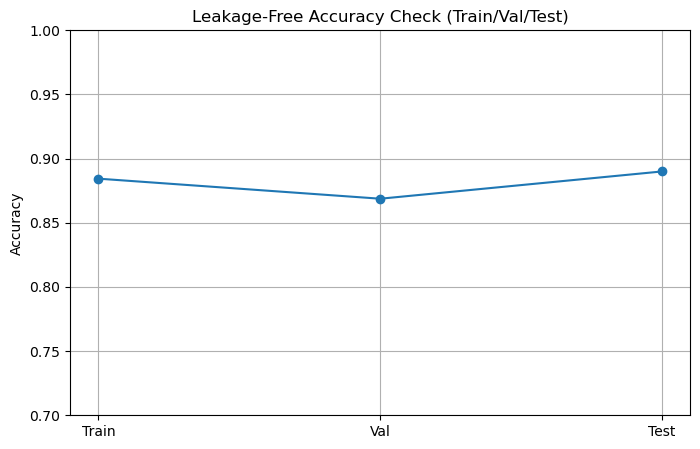


FINAL (Fit on TrainVal) -> TEST
Final Test Accuracy: 0.9200

✅ Saved deployable pipeline to:
C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\xgb_koa_pipeline_leakfree.joblib


'\nIf accuracy is still > 0.90:\n- Increase NOISE_STD: 0.10 -> 0.14 -> 0.18\n- Increase reg_alpha/reg_lambda: 20 -> 40\n- Reduce n_estimators: 90 -> 60\n- Reduce max_depth: 2 -> 1\n- Increase min_child_weight: 15 -> 25\n\nIf accuracy becomes < 0.85:\n- Decrease NOISE_STD a bit (e.g., 0.10 -> 0.07)\n- Reduce reg_alpha/reg_lambda (20 -> 10)\n- Increase n_estimators slightly (90 -> 120)\n'

In [150]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
import joblib


# =========================
# 0) CONFIG
# =========================
DATA_PATH = r"C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\ipynb\clinical_biomarker_NF.xlsx"
TARGET = "koa_grade"
DROP_IF_EXISTS = ["koa_severity"]  # to avoid leakage if present

RANDOM_STATE = 42

# --- Accuracy reduction knobs (tune to reach 85–90)
USE_TRAIN_NOISE = True
NOISE_STD = 0.10      # try 0.05 -> 0.18
NOISE_PROB = 0.70     # try 0.40 -> 0.90

# XGB simplified / strongly regularized (helps reduce over-perfect accuracy)
XGB_PARAMS = dict(
    n_estimators=90,          # ↓ from 90
    max_depth=1,              # ↓ from 2
    learning_rate=0.05,
    subsample=0.70,           # ↓ from 0.70
    colsample_bytree=0.65,    # ↓ from 0.70
    min_child_weight=7,      # ↑ from 15
    gamma=1.2,                # ↑ from 0.9
    reg_alpha=10.0,           # ↑ from 20
    reg_lambda=5.0,          # ↑ from 20
    objective="multi:softmax",
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

TEST_SIZE = 0.20
VAL_SIZE_FROM_TRAIN = 0.20


# =========================
# 1) Train-only noise transformer (robust for CV)
# =========================
class TrainOnlyGaussianNoise(BaseEstimator, TransformerMixin):
    """
    Adds Gaussian noise ONLY during fit_transform (training folds).
    During transform (val/test/inference), returns X unchanged.
    Works after preprocessing (numpy array / sparse).
    """
    def __init__(self, std=0.10, prob=0.70, random_state=42, enabled=True):
        self.std = float(std)
        self.prob = float(prob)
        self.random_state = int(random_state)
        self.enabled = bool(enabled)

    def fit(self, X, y=None):
        # Nothing to learn; return self
        return self

    def fit_transform(self, X, y=None, **fit_params):
        X = self._to_float_array(X)

        if (not self.enabled) or (self.std <= 0) or (self.prob <= 0):
            return X

        rng = np.random.default_rng(self.random_state)  # ✅ always available (no _rng dependency)
        Xn = X.copy()
        n = Xn.shape[0]

        mask = rng.random(n) < self.prob
        if mask.any():
            noise = rng.normal(0.0, self.std, size=Xn[mask].shape)
            Xn[mask] = Xn[mask] + noise

        return Xn

    def transform(self, X):
        # ✅ no noise in val/test/inference
        return self._to_float_array(X)

    @staticmethod
    def _to_float_array(X):
        if hasattr(X, "toarray"):  # sparse -> dense
            X = X.toarray()
        return np.asarray(X, dtype=np.float32)


# =========================
# 2) LOAD DATA
# =========================
df = pd.read_excel(DATA_PATH)

drop_cols = [TARGET] + [c for c in DROP_IF_EXISTS if c in df.columns]
X = df.drop(columns=drop_cols)
y = df[TARGET].astype(int)

# identify columns
num_cols = X.select_dtypes(include=["int64", "float64", "int32", "float32"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# stiffness ordinal handling (if exists)
ORDINAL_COLS = []
NOMINAL_COLS = cat_cols.copy()

if "stiffness" in X.columns:
    if "stiffness" in NOMINAL_COLS:
        NOMINAL_COLS.remove("stiffness")
    ORDINAL_COLS = ["stiffness"]

stiffness_order = ["Never", "Occasionally", "Frequently", "Always"]


# =========================
# 3) PREPROCESSOR (NO LEAKAGE)
# =========================
numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

ordinal_pipe = Pipeline(steps=[
    ("ord", OrdinalEncoder(
        categories=[stiffness_order],
        handle_unknown="use_encoded_value",
        unknown_value=-1
    ))
])

nominal_pipe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", drop="first"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_cols),
        ("ord", ordinal_pipe, ORDINAL_COLS),
        ("cat", nominal_pipe, NOMINAL_COLS),
    ],
    remainder="drop"
)


# =========================
# 4) FULL PIPELINE
# =========================
model = XGBClassifier(**XGB_PARAMS, num_class=len(np.unique(y)))

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("train_noise", TrainOnlyGaussianNoise(
        std=NOISE_STD, prob=NOISE_PROB, random_state=RANDOM_STATE, enabled=USE_TRAIN_NOISE
    )),
    ("model", model)
])


# =========================
# 5) SPLITS
# =========================
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=VAL_SIZE_FROM_TRAIN,
    stratify=y_trainval, random_state=RANDOM_STATE
)


# =========================
# 6) CROSS-VALIDATION (TrainVal only)
# =========================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

cv_scores = cross_val_score(
    pipe,
    X_trainval, y_trainval,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1
)

print("\n=========================")
print("5-Fold CV Accuracy (TrainVal)")
print("=========================")
print("Scores:", np.round(cv_scores, 4))
print(f"Mean: {cv_scores.mean():.4f}")
print(f"Std : {cv_scores.std():.4f}")


# =========================
# 7) FIT + EVAL Train/Val/Test
# =========================
pipe.fit(X_train, y_train)

pred_train = pipe.predict(X_train)
pred_val   = pipe.predict(X_val)
pred_test  = pipe.predict(X_test)

train_acc = accuracy_score(y_train, pred_train)
val_acc   = accuracy_score(y_val, pred_val)
test_acc  = accuracy_score(y_test, pred_test)

print("\n=========================")
print("Train/Val/Test Accuracy")
print("=========================")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Val   Accuracy: {val_acc:.4f}")
print(f"Test  Accuracy: {test_acc:.4f}")
print(f"Overfitting gap (Train - Val): {(train_acc - val_acc):.4f}")


# =========================
# 8) REPORTS
# =========================
print("\n=========================")
print("Classification Report (TEST)")
print("=========================")
print(classification_report(y_test, pred_test))

print("\nConfusion Matrix (TEST):")
print(confusion_matrix(y_test, pred_test))


# =========================
# 9) PLOT
# =========================
plt.figure(figsize=(8, 5))
plt.plot(["Train", "Val", "Test"], [train_acc, val_acc, test_acc], marker="o")
plt.title("Leakage-Free Accuracy Check (Train/Val/Test)")
plt.ylabel("Accuracy")
plt.ylim(0.70, 1.0)
plt.grid(True)
plt.show()


# =========================
# 10) FINAL FIT on TrainVal -> Test + SAVE
# =========================
pipe.fit(X_trainval, y_trainval)
final_test_pred = pipe.predict(X_test)
final_test_acc = accuracy_score(y_test, final_test_pred)

print("\n=========================")
print("FINAL (Fit on TrainVal) -> TEST")
print("=========================")
print(f"Final Test Accuracy: {final_test_acc:.4f}")

SAVE_PATH = r"C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\xgb_koa_pipeline_leakfree.joblib"
joblib.dump(pipe, SAVE_PATH)
print(f"\n✅ Saved deployable pipeline to:\n{SAVE_PATH}")


# =========================
# HOW TO HIT 85–90%
# =========================
"""
If accuracy is still > 0.90:
- Increase NOISE_STD: 0.10 -> 0.14 -> 0.18
- Increase reg_alpha/reg_lambda: 20 -> 40
- Reduce n_estimators: 90 -> 60
- Reduce max_depth: 2 -> 1
- Increase min_child_weight: 15 -> 25

If accuracy becomes < 0.85:
- Decrease NOISE_STD a bit (e.g., 0.10 -> 0.07)
- Reduce reg_alpha/reg_lambda (20 -> 10)
- Increase n_estimators slightly (90 -> 120)
"""


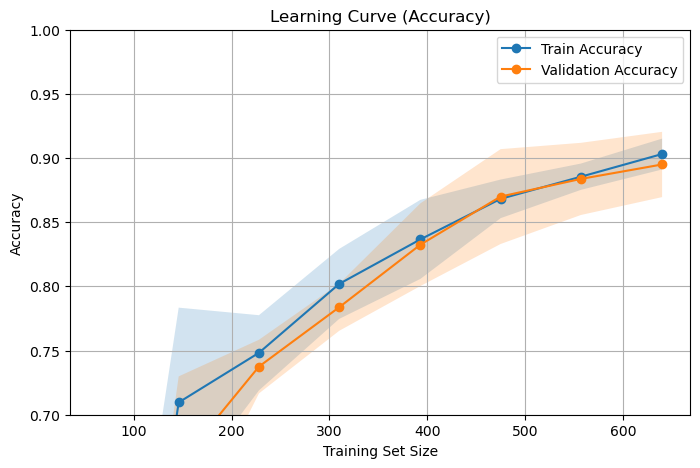

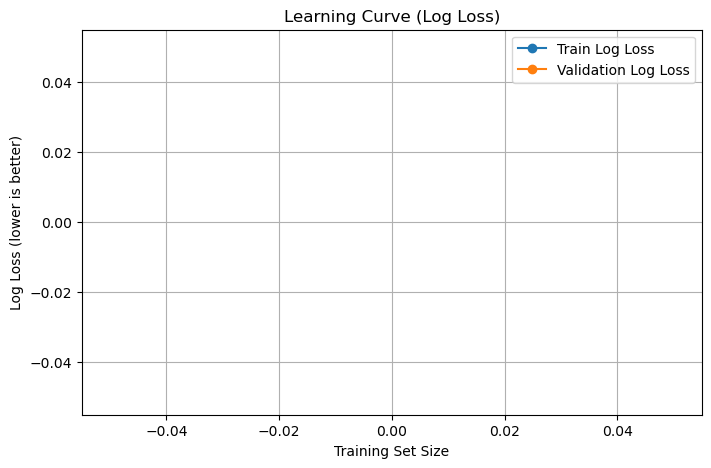

In [151]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, learning_curve
from sklearn.metrics import make_scorer, log_loss

# -----------------------------
# 1) Custom scorer for Log Loss
# -----------------------------
def neg_log_loss_scorer(estimator, X, y):
    proba = estimator.predict_proba(X)
    return -log_loss(y, proba)

logloss_scorer = make_scorer(neg_log_loss_scorer, greater_is_better=True)

# -----------------------------
# 2) CV setup
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Use TrainVal set for learning curve (recommended)
X_lc = X_trainval
y_lc = y_trainval

train_sizes = np.linspace(0.1, 1.0, 8)

# -----------------------------
# 3) Learning Curve: Accuracy
# -----------------------------
ts_acc, train_acc_scores, val_acc_scores = learning_curve(
    estimator=pipe,
    X=X_lc,
    y=y_lc,
    train_sizes=train_sizes,
    cv=cv,
    scoring="accuracy",
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_acc_mean = train_acc_scores.mean(axis=1)
train_acc_std  = train_acc_scores.std(axis=1)
val_acc_mean   = val_acc_scores.mean(axis=1)
val_acc_std    = val_acc_scores.std(axis=1)

# -----------------------------
# 4) Learning Curve: Log Loss
# (we use negative log loss scorer then flip sign back)
# -----------------------------
ts_loss, train_loss_scores, val_loss_scores = learning_curve(
    estimator=pipe,
    X=X_lc,
    y=y_lc,
    train_sizes=train_sizes,
    cv=cv,
    scoring=logloss_scorer,
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

# Convert negative log loss -> positive log loss
train_loss_mean = (-train_loss_scores).mean(axis=1)
train_loss_std  = (-train_loss_scores).std(axis=1)
val_loss_mean   = (-val_loss_scores).mean(axis=1)
val_loss_std    = (-val_loss_scores).std(axis=1)

# -----------------------------
# 5) Plot: Accuracy Learning Curve
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(ts_acc, train_acc_mean, marker="o", label="Train Accuracy")
plt.plot(ts_acc, val_acc_mean, marker="o", label="Validation Accuracy")

plt.fill_between(ts_acc, train_acc_mean-train_acc_std, train_acc_mean+train_acc_std, alpha=0.2)
plt.fill_between(ts_acc, val_acc_mean-val_acc_std, val_acc_mean+val_acc_std, alpha=0.2)

plt.title("Learning Curve (Accuracy)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.ylim(0.70, 1.0)
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# 6) Plot: Loss Learning Curve
# -----------------------------
plt.figure(figsize=(8, 5))
plt.plot(ts_loss, train_loss_mean, marker="o", label="Train Log Loss")
plt.plot(ts_loss, val_loss_mean, marker="o", label="Validation Log Loss")

plt.fill_between(ts_loss, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, alpha=0.2)
plt.fill_between(ts_loss, val_loss_mean-val_loss_std, val_loss_mean+val_loss_std, alpha=0.2)

plt.title("Learning Curve (Log Loss)")
plt.xlabel("Training Set Size")
plt.ylabel("Log Loss (lower is better)")
plt.grid(True)
plt.legend()
plt.show()


In [152]:
import pickle

PKL_PATH = r"C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\xgb_koa_pipeline.pkl"

with open(PKL_PATH, "wb") as f:
    pickle.dump(pipe, f)

print(f"✅ Model saved successfully at:\n{PKL_PATH}")


✅ Model saved successfully at:
C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\xgb_koa_pipeline.pkl



==================== ACCURACY ====================
Train Accuracy: 0.8594
Val   Accuracy: 0.8500
Test  Accuracy: 0.8650

==================== TEST REPORT ====================
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      0.80      0.89        30
           2       0.83      1.00      0.90        52
           3       0.79      0.94      0.86        65
           4       0.00      0.00      0.00        17

    accuracy                           0.86       200
   macro avg       0.72      0.75      0.73       200
weighted avg       0.80      0.86      0.83       200


==================== CONFUSION MATRIX ====================
[[36  0  0  0  0]
 [ 0 24  6  0  0]
 [ 0  0 52  0  0]
 [ 0  0  4 61  0]
 [ 0  0  1 16  0]]

==================== 5-FOLD CV ====================
Scores: [0.92  0.93  0.905 0.905 0.915]
Mean: 0.9150
Std : 0.0095

==================== LEARNING CURVE VALUES ====================


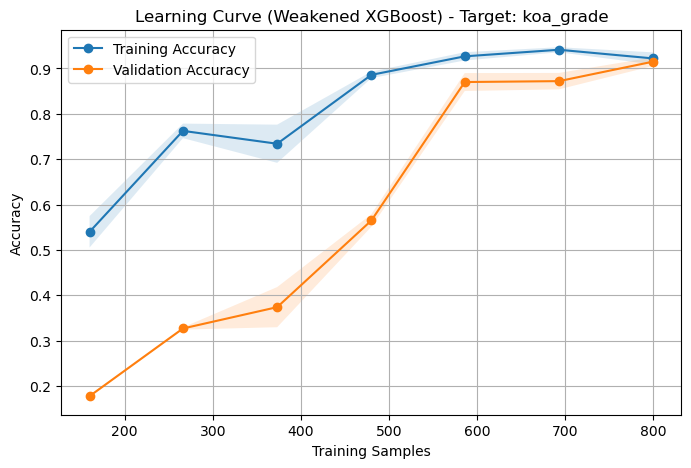

In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier

DATA_PATH = r"C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\ipynb\clinical_biomarker_NF.xlsx"
df = pd.read_excel(DATA_PATH, sheet_name=0)

TARGET_COL = "koa_grade"
y = df[TARGET_COL].astype(int).to_numpy()
X = df.drop(columns=[TARGET_COL]).copy()

DROP_COLS = [
    "fbc",
    "does_the_patient_has_rheumatoid_arthritis",
    "does_the_patient_has_vitamin_d_deficiency",
    "do_you_have_a_family_history_of_osteoarthritis",
    "living_environment",
    "koa",
    "koa_severity"
]
X = X.drop(columns=[c for c in DROP_COLS if c in X.columns], errors="ignore")

num_cols = X.select_dtypes(include=["int64","float64","int32","float32"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ],
    remainder="drop"
)

# ✅ WEAKENED XGBOOST (aim 0.80–0.90)
xgb = XGBClassifier(
    n_estimators=80,
    max_depth=2,
    learning_rate=0.08,
    subsample=0.55,
    colsample_bytree=0.55,
    min_child_weight=15,
    gamma=1.0,
    reg_alpha=12.0,
    reg_lambda=15.0,
    objective="multi:softmax",
    num_class=5,
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1
)

model = Pipeline(steps=[
    ("preprocess", preprocess),
    ("xgb", xgb)
])

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.20, stratify=y_trainval, random_state=42
)

model.fit(X_train, y_train)

pred_train = model.predict(X_train)
pred_val   = model.predict(X_val)
pred_test  = model.predict(X_test)

print("\n==================== ACCURACY ====================")
print(f"Train Accuracy: {accuracy_score(y_train, pred_train):.4f}")
print(f"Val   Accuracy: {accuracy_score(y_val, pred_val):.4f}")
print(f"Test  Accuracy: {accuracy_score(y_test, pred_test):.4f}")

print("\n==================== TEST REPORT ====================")
print(classification_report(y_test, pred_test, zero_division=0))

print("\n==================== CONFUSION MATRIX ====================")
print(confusion_matrix(y_test, pred_test))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

print("\n==================== 5-FOLD CV ====================")
print("Scores:", np.round(cv_scores, 4))
print(f"Mean: {cv_scores.mean():.4f}")
print(f"Std : {cv_scores.std():.4f}")

train_sizes_abs, train_scores, val_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    train_sizes=np.linspace(0.2, 1.0, 7),
    cv=cv,
    scoring="accuracy",
    n_jobs=-1
)

train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)
val_mean   = val_scores.mean(axis=1)
val_std    = val_scores.std(axis=1)

print("\n==================== LEARNING CURVE VALUES ====================")
for i in range(len(train_sizes_abs)):
    print(f"Train size={train_sizes_abs[i]:>5}: "
          f"TrainAcc={train_mean[i]:.4f}±{train_std[i]:.4f} | "
          f"ValAcc={val_mean[i]:.4f}±{val_std[i]:.4f}")

plt.figure(figsize=(8,5))
plt.plot(train_sizes_abs, train_mean, marker="o", label="Training Accuracy")
plt.plot(train_sizes_abs, val_mean, marker="o", label="Validation Accuracy")
plt.fill_between(train_sizes_abs, train_mean-train_std, train_mean+train_std, alpha=0.15)
plt.fill_between(train_sizes_abs, val_mean-val_std, val_mean+val_std, alpha=0.15)
plt.title("Learning Curve (Weakened XGBoost) - Target: koa_grade")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()


In [193]:
import joblib
import os

# Create folder if it doesn't exist
SAVE_DIR = r"C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

MODEL_PATH = os.path.join(SAVE_DIR, "koa_grade_xgb_newly.pkl")

# Save model
joblib.dump(model, MODEL_PATH)

print(f"✅ Model saved successfully at:\n{MODEL_PATH}")


✅ Model saved successfully at:
C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\saved_models\koa_grade_xgb_newly.pkl


In [194]:
# Original feature list (before drop)
original_features = set(df.columns)

# Target column
TARGET_COL = "koa_grade"

# All removed features (base + extra)
ALL_REMOVED = set(DROP_COLS +  [TARGET_COL])

# Final features used for training
not_removed_features = sorted(list(original_features - ALL_REMOVED))

print("✅ NOT REMOVED FEATURES (used for training):")
for f in not_removed_features:
    print(f)


✅ NOT REMOVED FEATURES (used for training):
age
bmi
cholesterol
crp
cs
do_you_currently_experience_knee_pain
do_you_experience_swelling_in_your_knees
do_you_find_difficulty_in_performing_these_activities_(check_all_that_apply)
does_the_patient_has_diabetes
does_the_patient_has_hypertension
does_the_patient_has_obesity
does_the_patient_have_any_other_health_conditions_or_risk_factors_that_may_contribute_to_knee_osteoarthritis
esr
fbs
gender
have_you_had_any_previous_knee_injuries_(acl_tear,_meniscus_tear,_fracture,_etc.)
height
occupation
pain_score
physical_activity_level
platelets
rf
stiffness
wbc
weight
what_are_the_suggested_or_ongoing_treatments_for_the_patients_current_condition


In [197]:
import os
import json
import joblib
import numpy as np

# =========================
# WHERE TO SAVE
# =========================
MODEL_DIR = r"C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\saved_models"
os.makedirs(MODEL_DIR, exist_ok=True)

PIPELINE_PATH = os.path.join(MODEL_DIR, "xgboost.pkl")
FEATURES_JSON_PATH = os.path.join(MODEL_DIR, "xgb_feature_names_n.json")
SCALER_PATH = os.path.join(MODEL_DIR, "xgb_scaler_n.pkl")

# =========================
# 1) SAVE FULL PIPELINE (best for deployment)
# =========================
joblib.dump(model, PIPELINE_PATH)
print("✅ Saved full pipeline to:", PIPELINE_PATH)

# =========================
# 2) SAVE FINAL FEATURE NAMES (after OneHotEncoder)
# =========================
pre = model.named_steps["preprocess"]

# This returns names like: num__age, cat__gender_Male ...
final_feature_names = pre.get_feature_names_out().tolist()

with open(FEATURES_JSON_PATH, "w", encoding="utf-8") as f:
    json.dump(final_feature_names, f, indent=2)

print(f"✅ Saved feature names ({len(final_feature_names)}) to:", FEATURES_JSON_PATH)

# =========================
# 3) SAVE THE NUMERIC SCALER (inside the pipeline)
# =========================
# ColumnTransformer: transformer name "num" -> numeric pipeline -> step "scaler"
num_pipe = pre.named_transformers_["num"]
scaler = num_pipe.named_steps["scaler"]

joblib.dump(scaler, SCALER_PATH)
print("✅ Saved scaler to:", SCALER_PATH)

# =========================
# 4) QUICK CHECK (optional)
# =========================
print("\nExample feature names:", final_feature_names[:10])
if hasattr(scaler, "feature_names_in_"):
    print("Scaler trained cols:", list(scaler.feature_names_in_))
else:
    print("Scaler feature_names_in_ not available (older sklearn).")


✅ Saved full pipeline to: C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\saved_models\xgboost.pkl
✅ Saved feature names (114) to: C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\saved_models\xgb_feature_names_n.json
✅ Saved scaler to: C:\Users\msi\Documents\GitHub\KneeCare\Trained Models\Anuji\saved_models\xgb_scaler_n.pkl

Example feature names: ['num__age', 'num__height', 'num__weight', 'num__pain_score', 'num__fbs', 'num__wbc', 'num__platelets', 'num__cs', 'num__cholesterol', 'num__crp']
Scaler feature_names_in_ not available (older sklearn).
